In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sys

sys.path.insert(1, '../')

from cgh4_calculator import get_multiplicities, rep_label_list, irrep_index
import pandas as pd
from moments_operator import Operator, OperatorDict_from_database
from utilities import all_equal

In [2]:
V,A = (4,1), (4,4)
n = 3

In [3]:
get_multiplicities(V,V)
get_multiplicities(V,V,V)
get_multiplicities(*(V,) * n)

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 1, 0, 0, 0, 0, 3, 2]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 1, 0, 0, 0, 0, 3, 2]

In [4]:
available_irreps = {rep_label_list[i] : (mul,"Y") for i, mul in enumerate(get_multiplicities(*(V,) * n)) if mul>0}
available_irreps

for i_dim in range(2,n):
    low_dim_irrep = get_multiplicities(*(V,) * i_dim)

    for key in available_irreps.keys():
        if low_dim_irrep[irrep_index[key]] > 0:
            available_irreps[key] = (available_irreps[key][0], "N")
available_irreps

{(4, 1): (4, 'Y'),
 (4, 2): (1, 'Y'),
 (4, 4): (1, 'Y'),
 (8, 1): (3, 'Y'),
 (8, 2): (2, 'Y')}

{(4, 1): (4, 'Y'),
 (4, 2): (1, 'Y'),
 (4, 4): (1, 'Y'),
 (8, 1): (3, 'Y'),
 (8, 2): (2, 'Y')}

In [5]:
df = pd.DataFrame([ [k, v[0], v[1]] for k,v in available_irreps.items() ], index=available_irreps.keys(), columns=["Irrep", "Multiplicity", "Mixing Safe"])
df

Irrep  Multiplicity Mixing Safe
4 1  (4, 1)             4           Y
  2  (4, 2)             1           Y
  4  (4, 4)             1           Y
8 1  (8, 1)             3           Y
  2  (8, 2)             2           Y

In [6]:
print(df.to_string())

      Irrep  Multiplicity Mixing Safe
4 1  (4, 1)             4           Y
  2  (4, 2)             1           Y
  4  (4, 4)             1           Y
8 1  (8, 1)             3           Y
  2  (8, 2)             2           Y


In [7]:
type(df)

pandas.core.frame.DataFrame

In [26]:
def decomposition_analysis(X: str, n_der: int, operator_dict:dict[dict[list[Operator]]]|None=None, verbose:bool=False) -> pd.core.frame.DataFrame:
    """
    Function Performing the analysis of tensor product of the kind irrep x irrep x ... x irrep (n times),
    to asses which irrep in the decomposion is suitable to be studied without having to worry about
    renornalization problems.

    Input:
        - X: str, either 'V', 'A' or 'T', for vector, axial or tensorial, corresponding to the first irrep in the tensor product being
             either (4,1), (4,4) or (4,1)x(4,1)
        - n_der: int, number of derivatives in the tensor product, corresponding the the number of times the irrep
                 (4,1) appears in the tensor product (after the first irrep(s))
        - operator_database: dictionaries containing the list of the operators, if given information on index symmetry is also provided
        - verbose: bool, if True info are printed to screen
    
    Output:
        - analysis_dataframe: pandas dataframe with all the information regarding the irreps in the decomposition
    """

    # Check the input
    if X not in ['V', 'A', 'T']:
        raise ValueError("X must be either 'V', 'A' or 'T")
    if not isinstance(n_der, int) or n_der < 1:
        raise ValueError("n_der must be a positive integer")
    if not isinstance(verbose, bool):
        raise ValueError("verbose must be a boolean")
    
    #we select the chosen starting irrep depending on X
    starting_irrep = ((4,1),) if X=='V' else ((4,4),) if X=='A' else ((4,1),(4,1),)

    # Get the multiplicities of the irreps in the decomposition (and by default set to "Y" the mixing safe property)
    available_irreps = {rep_label_list[i] : ["Y", mul, "-"] for i, mul in enumerate(get_multiplicities(*( starting_irrep + (V,) * n_der))) if mul>0}

    #we set to not mix safe the scalar/psedudoscalar if present
    if X=='V' and (1,1) in available_irreps.keys():
        available_irreps[(1,1)][0] = "N"
    if X=='A' and (1,4) in available_irreps.keys():
        available_irreps[(1,4)][0] = "N"

    #we set to not mix safe the fundamental/pseudofunamental if present
    if X=='V' and (4,1) in available_irreps.keys():
        available_irreps[(4,1)][0] = "N"
    if X=='A' and (4,4) in available_irreps.keys():
        available_irreps[(4,4)][0] = "N"

    # We now loop over lower dimensional irreps decomposition of the same kind
    for i_dim in range(1,n_der):

        #we get the multiplicities of the irreps in the decomposition of a lower dimension
        low_dim_irrep = get_multiplicities( *( starting_irrep + (V,) * i_dim) )

        #if a given irrep is also present in a lower dimensional decomposition then we set the "mixing safe" property to "N"
        for key in available_irreps.keys():
            if low_dim_irrep[irrep_index[key]] > 0:
                available_irreps[key] = (available_irreps[key][0], "N")

    #if the operator_database is given we look at the symmetry property of the irreps
    if operator_dict is not None:

        #we loop over the irreps in the decompostion
        for key in available_irreps.keys():

            #if the multiplicity is 1 we asses the index symmetry condition
            if available_irreps[key][1] == 1:

                #we get the list of the operators in the operator_database of the selected irrep
                op_list = operator_dict[( n_der+1 if X in ['V','A'] else n_der+2 ,X)][key,1]

                #we construct the lyst with the symmetry condition for all the given operators
                symm_list = [op.symm for op in op_list]

                #we asses the symmetry condition
                available_irreps[key][2] = symm_list[0][0] if all_equal(symm_list) else 'Mixed'



    # Create a pandas dataframe with the information
    df = pd.DataFrame([ [k, *v] for k,v in available_irreps.items() ], index=available_irreps.keys(), columns=["Irrep", "Mixing Safe", "Multiplicity", "Symmetry"])

    #if the operator database was not given we remove the symmetry column
    if operator_dict is None or X=='T':
        df = df.drop(columns=["Symmetry"])

    #if verbose is True we print the dataframe to screen
    if verbose:
        print(f"\nAnalysis of the irreps in the tensor decompositon { ' x '.join( [ str(e) for e in ( starting_irrep + (V,) * n_der) ] ) } :\n")
        print(df.to_string())

    return df

In [9]:
(A + (V,) * n)

(4, 4, (4, 1), (4, 1), (4, 1))

In [10]:
( ((4,1) if 'V'=='V' else (4,4)) + (V,) * 1)
get_multiplicities(*( ( (4,1) if 'V'=='V' else (4,4) , )  + (V,) * 1))

(4, 1, (4, 1))

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

In [11]:
op_dict = OperatorDict_from_database("../operator_database")

In [12]:
op_dict[(3,'V')].keys()

dict_keys([((4, 1), 1), ((4, 1), 2), ((4, 1), 3), ((4, 1), 4), ((4, 2), 1), ((4, 4), 1), ((8, 1), 1), ((8, 1), 2), ((8, 1), 3), ((8, 2), 1), ((8, 2), 2)])

In [27]:
df = decomposition_analysis('V', 1, operator_dict=op_dict, verbose=True)
df = decomposition_analysis('V', 2, operator_dict=op_dict, verbose=True)
df = decomposition_analysis('A', 1, operator_dict=op_dict, verbose=True)
df = decomposition_analysis('A', 2, operator_dict=op_dict, verbose=True)


Analysis of the irreps in the tensor decompositon (4, 1) x (4, 1) :

      Irrep Mixing Safe  Multiplicity Symmetry
1 1  (1, 1)           N             1        S
3 1  (3, 1)           Y             1        S
6 1  (6, 1)           Y             1        A
  3  (6, 3)           Y             1        S

Analysis of the irreps in the tensor decompositon (4, 1) x (4, 1) x (4, 1) :

      Irrep Mixing Safe  Multiplicity Symmetry
4 1  (4, 1)           N             4        -
  2  (4, 2)           Y             1        S
  4  (4, 4)           Y             1        A
8 1  (8, 1)           Y             3        -
  2  (8, 2)           Y             2        -

Analysis of the irreps in the tensor decompositon (4, 4) x (4, 1) :

      Irrep Mixing Safe  Multiplicity Symmetry
1 4  (1, 4)           N             1        S
3 4  (3, 4)           Y             1        S
6 1  (6, 1)           Y             1        A
  4  (6, 4)           Y             1        S

Analysis of the irreps in th

In [28]:
df = decomposition_analysis('T', 1, operator_dict=op_dict, verbose=True)
df = decomposition_analysis('T', 2, operator_dict=op_dict, verbose=True)


Analysis of the irreps in the tensor decompositon (4, 1) x (4, 1) x (4, 1) :

      Irrep Mixing Safe  Multiplicity
4 1  (4, 1)           Y             4
  2  (4, 2)           Y             1
  4  (4, 4)           Y             1
8 1  (8, 1)           Y             3
  2  (8, 2)           Y             2

Analysis of the irreps in the tensor decompositon (4, 1) x (4, 1) x (4, 1) x (4, 1) :

      Irrep Mixing Safe  Multiplicity
1 1  (1, 1)           Y             4
  2  (1, 2)           Y             1
  4  (1, 4)           Y             1
2 1  (2, 1)           Y             3
  2  (2, 2)           Y             2
3 1  (3, 1)           Y             7
  2  (3, 2)           Y             3
  3  (3, 3)           Y             3
  4  (3, 4)           Y             3
6 1  (6, 1)           Y            10
  2  (6, 2)           Y             6
  3  (6, 3)           Y            10
  4  (6, 4)           Y             6



Irrep Mixing Safe  Multiplicity Symmetry
(4, 1)           N             4        -
(4, 2)           Y             1        S
(4, 4)           Y             1        A
(8, 1)           Y             3        -
(8, 2)           Y             2        -


Hi Jeremy,


as my data analysis routines are almost completed, I began to have a look into the choice for the two derivatives operators.


If I understood correctly, I should choose operators that are symmetric and traceless, and that belong to an irrep with multiplicity one and that does not appear in the decomposition of the tensor product related to lower dimensional operators with the same Dirac structure.

Given these requirements, I have identified, for the vector and axial case, the following irreps:
 - Vector: (4,2)
 - Axial: (4,3)
The operators belonging to such irreps are given in the attached pdfs.


If then I consider also the additional requirement that I need a non zero kinematic factor, I encounter some problems with the vector operators because their kinematic factors are all proportional to P_i P_j, with i≠j.

In the dataset I have, only one component of the momentum (P_x) is different from 0, hence I am not able to extract the moments from the selected vector operators.


Regarding instead the tensor operators with two derivatives (four indices in total), I am not sure how I should proceed.

The only two irreps with multiplicity one in the decomposition are (1,2) and (1,4), which are respectively completely symmetric and completely antisymmetric in all four indices, hence they have always a 0 kinematic factor.


If you want I can also send you the complete list with all the operators, as well as a couple of tables I generated to sum up the properties of the irreps appearing in the decomposition.


Let me know if you have any idea regarding how I should proceed.
Thanks in advance for your response.


Best regards,

Emilio Taggi

In [14]:
" x ".join( [ str(e) for e in [*(V,) * n] ] )

'(4, 1) x (4, 1) x (4, 1)'

# Dataset Analysis

In [15]:
from moments_toolkit import moments_toolkit, average_moments_over_T
import os
import numpy as np

In [16]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"

opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_px-2_q0",
                            operator_folder= "../operator_database",
                            momentum='PX-2_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [17]:
opAnalyzer.select_operator(115, 166)

opAnalyzer.get_Klist()
opAnalyzer.remove_zeroK_operators()

opAnalyzer

opAnalyzer.display_operators()

[0 ± 0, -0.2949(25)]

Instance of the moments_toolkit class

Dataset Specifics:
Number of configurations: 212
P: [-2  0  0]
q: [0 0 0]

Current Selection of Parameters:
Number of Selected Operators: 1
Selected Isospin: U-D
Selected T values: [3, 4, 5, 6, 7, 8, 10, 12]

Fit parameters:
 - Central Value Fit:            True
 - Central Value Fit Correlated: True
 - Resample Fit:                 False
 - Resample Fit Correlated:      False
 - Resample Fit Resample Prior:  False
 - SVD Cut: None
 - Max Iterations: 10000

Resampling Technique: jackknife
Number of resamples: 212

<IPython.core.display.Math object>

In [18]:
from sympy import I
op = opAnalyzer.get_operator(115)

op.K#.simplify(rational=True)
op.p3corr_is_real

( I in op.K.atoms() ) if op.nder%2==1 else ( I not in op.K.atoms() )

6*p_1*p_2

True

True

In [19]:
#opAnalyzer.operator_show()

[-0.2949(25)]

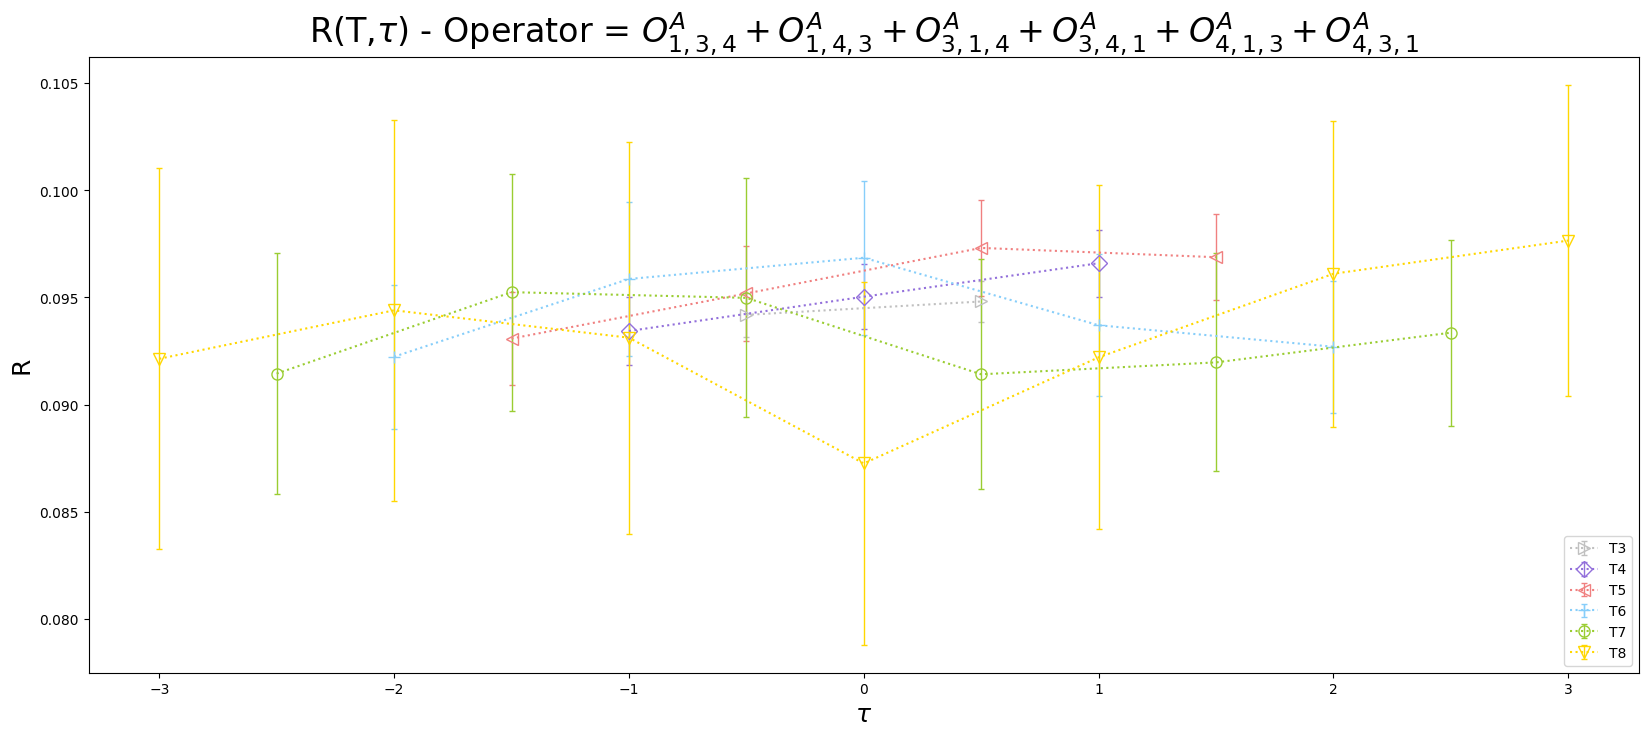

In [20]:
opAnalyzer.deselect_operator()
opAnalyzer.select_operator(115, 166)
opAnalyzer.remove_zeroK_operators()
opAnalyzer.get_Klist()
opAnalyzer.remove_T()
opAnalyzer.remove_T(10,12)
_ = opAnalyzer.plot_R(rescale=True)

/wsgjsc/home/taggi1/workspace_folders/PhD_work/moments_pdf/test_notebooks/../moments_toolkit.py:1866: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


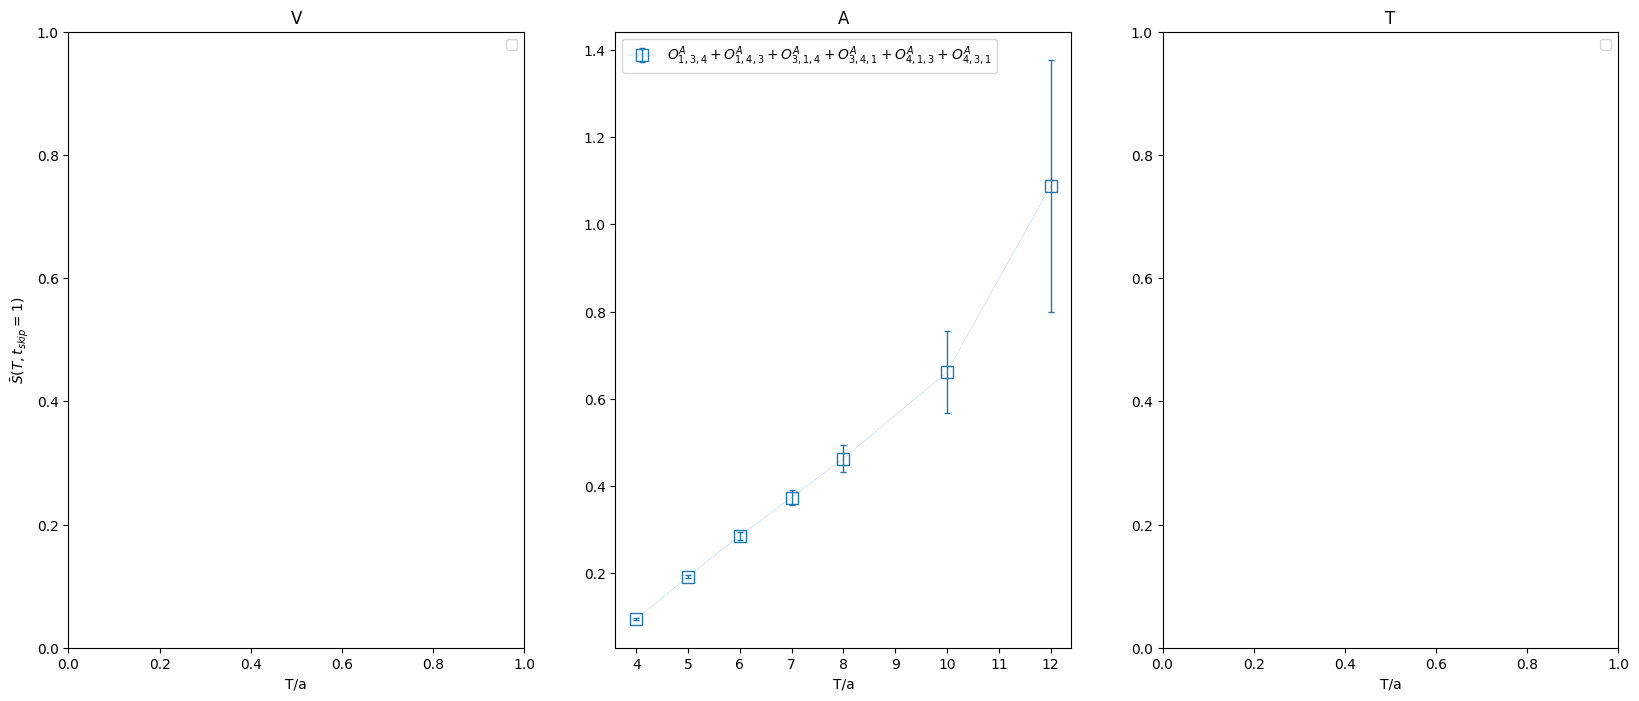

In [21]:
opAnalyzer.remove_T()
_ = opAnalyzer.plot_S(tskip=1,rescale=True)

In [22]:
opAnalyzer.get_M_from_S(moments=True)

avg, iTmin = average_moments_over_T( opAnalyzer.get_M_from_S(moments=True) , chi2=1.0)
avg, iTmin

array([[0 ± 0, 0.0953(39), 0.0916(77), 0.088(10), 0.094(19), 0.110(32),
        0.16(11), 0 ± 0]], dtype=object)

(0.0941(33), 0)

In [23]:
# opAnalyzer.focus_paper_operators()
# opAnalyzer.display_operators()

# for op in opAnalyzer.selected_op:
#     op.K